# TM10007 Assignment ECG - group 3

### Imports

In [1]:
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn

from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA 
from sklearn.feature_selection import SelectKBest, chi2, SequentialFeatureSelector
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2, SequentialFeatureSelector
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer
from IPython.display import display
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from itertools import combinations
from scipy.stats import ttest_rel


### Data loading, save features and labels into dataframe 

In [2]:
with zipfile.ZipFile('./ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./ecg/')

data = pd.read_csv('./ecg/ecg_data.csv', index_col=0)

file = './ecg/ecg_data.csv'
if(os.path.exists(file) and os.path.isfile(file)):
  os.remove(file)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

y = data.label
X = data.drop('label', axis=1)

The number of samples: 827
The number of columns: 9001


## PCA plot to visualize data

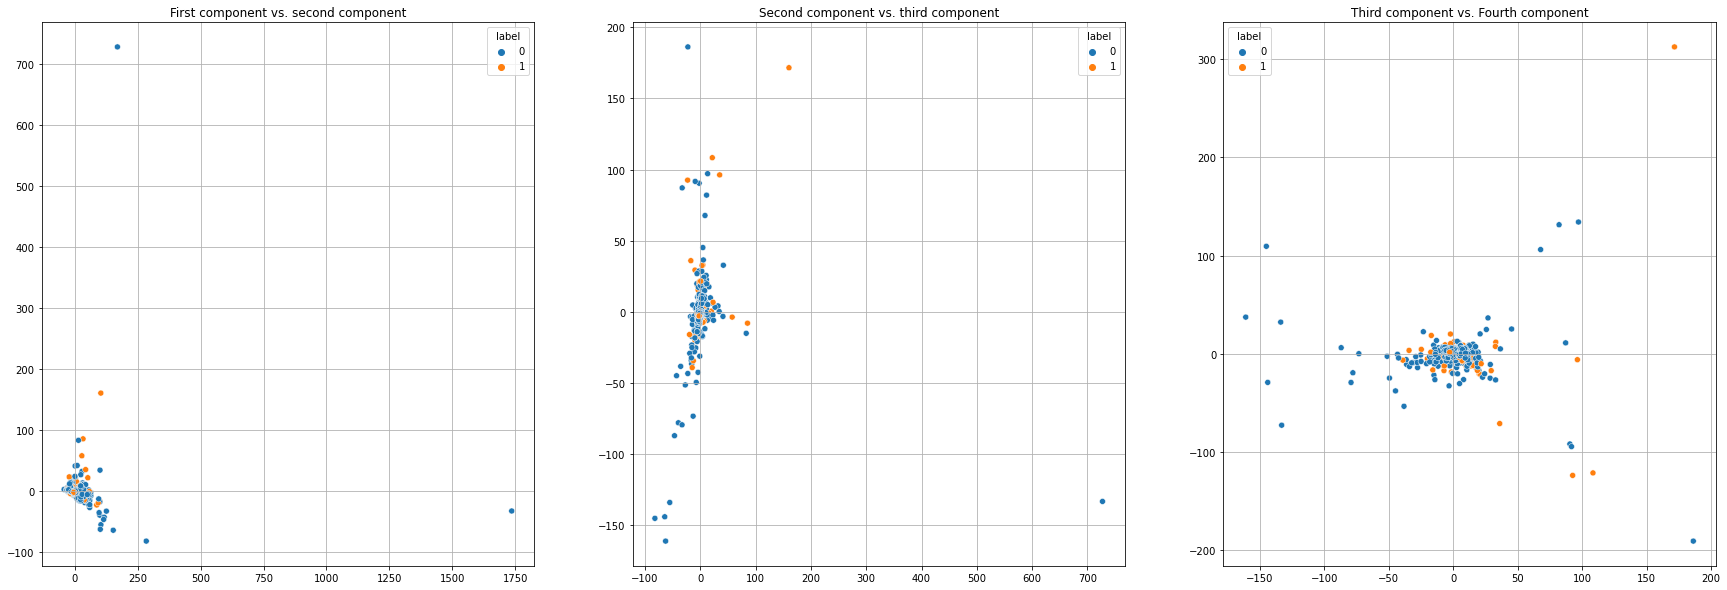

In [3]:
# PCA plot of all data
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

# we dachten PCA scatterplots van verschillende data toevoegen in subplot 
pca = PCA()
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

fig, axs = plt.subplots(1, 3, figsize=(30,10))
seaborn.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, ax=axs[0])
axs[0].set_title('First component vs. second component')
axs[0].grid()
seaborn.scatterplot(x=X_pca[:, 1], y=X_pca[:, 2], hue=y, ax=axs[1])
axs[1].set_title('Second component vs. third component')
axs[1].grid()
seaborn.scatterplot(x=X_pca[:, 2], y=X_pca[:, 3], hue=y, ax=axs[2])
axs[2].set_title('Third component vs. Fourth component')
axs[2].grid()

(0.0, 75.0)

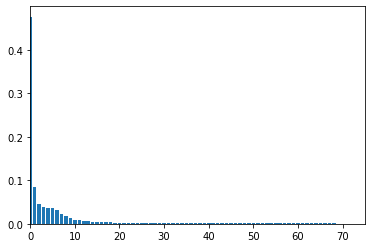

In [4]:
plt.bar(x=range(pca.explained_variance_ratio_.shape[0]), height=pca.explained_variance_ratio_)
plt.xlim([0, 75])

### Learning Curve function 

In [5]:
def plot_learning_curve(clf, X_train, y_train, plot):
    train_size, train_scores, test_scores = learning_curve(clf, X_train, y_train, verbose=2, scoring='roc_auc')
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plot.plot(train_size, train_mean, color='b', label='training')
    plot.plot(train_size, test_mean, color='orange', label='validation')

    plot.fill_between(train_size, train_mean-train_std, train_mean+train_std, color='b', alpha=0.3)
    plot.fill_between(train_size, test_mean-test_std, test_mean+test_std, color='orange', alpha=0.3)
    
    plot.grid()
    plot.set_ylim([0.5, 1.1])
    plot.set_xlabel('Training examples')
    plot.set_ylabel('ROC-AUC Score')
    plot.legend()

# Constants

In [6]:
N_SPLITS = 5 # number of splits for outer validation loop
RANDOM_SEED = 42 # get reproducable splits for the different models

# Random forest classifier 

### Loop of test-training  and evaluation loop

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END pca__n_components=1, random_forest__bootstrap=True, random_forest__max_depth=30, random_forest__max_features=sqrt, random_forest__min_samples_leaf=1, random_forest__n_estimators=187; total time=   0.9s
[CV] END pca__n_components=1, random_forest__bootstrap=True, random_forest__max_depth=30, random_forest__max_features=sqrt, random_forest__min_samples_leaf=1, random_forest__n_estimators=187; total time=   1.0s
[CV] END pca__n_components=1, random_forest__bootstrap=True, random_forest__max_depth=30, random_forest__max_features=sqrt, random_forest__min_samples_leaf=1, random_forest__n_estimators=187; total time=   0.7s
[CV] END pca__n_components=None, random_forest__bootstrap=True, random_forest__max_depth=20, random_forest__max_features=sqrt, random_forest__min_samples_leaf=5, random_forest__n_estimators=80; total time=   0.9s
[CV] END pca__n_components=None, random_forest__bootstrap=True, random_forest__max_depth=20, 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   0.9s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   0.9s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.6s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   21.4s finished


[CV] END pca__n_components=1, random_forest__bootstrap=True, random_forest__max_depth=30, random_forest__max_features=sqrt, random_forest__min_samples_leaf=1, random_forest__n_estimators=187; total time=   0.7s
[CV] END pca__n_components=1, random_forest__bootstrap=True, random_forest__max_depth=30, random_forest__max_features=sqrt, random_forest__min_samples_leaf=1, random_forest__n_estimators=187; total time=   0.7s
[CV] END pca__n_components=1, random_forest__bootstrap=True, random_forest__max_depth=30, random_forest__max_features=sqrt, random_forest__min_samples_leaf=1, random_forest__n_estimators=187; total time=   0.7s
[CV] END pca__n_components=None, random_forest__bootstrap=True, random_forest__max_depth=20, random_forest__max_features=sqrt, random_forest__min_samples_leaf=5, random_forest__n_estimators=80; total time=   0.9s
[CV] END pca__n_components=None, random_forest__bootstrap=True, random_forest__max_depth=20, random_forest__max_features=sqrt, random_forest__min_samples_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   1.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   0.9s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.6s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   19.3s finished


[CV] END pca__n_components=1, random_forest__bootstrap=True, random_forest__max_depth=30, random_forest__max_features=sqrt, random_forest__min_samples_leaf=1, random_forest__n_estimators=187; total time=   0.9s
[CV] END pca__n_components=1, random_forest__bootstrap=True, random_forest__max_depth=30, random_forest__max_features=sqrt, random_forest__min_samples_leaf=1, random_forest__n_estimators=187; total time=   0.7s
[CV] END pca__n_components=1, random_forest__bootstrap=True, random_forest__max_depth=30, random_forest__max_features=sqrt, random_forest__min_samples_leaf=1, random_forest__n_estimators=187; total time=   0.7s
[CV] END pca__n_components=None, random_forest__bootstrap=True, random_forest__max_depth=20, random_forest__max_features=sqrt, random_forest__min_samples_leaf=5, random_forest__n_estimators=80; total time=   0.8s
[CV] END pca__n_components=None, random_forest__bootstrap=True, random_forest__max_depth=20, random_forest__max_features=sqrt, random_forest__min_samples_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   1.1s
[CV] END .................................................... total time=   1.3s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   1.0s
[CV] END .................................................... total time=   1.4s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.8s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   24.5s finished


[CV] END pca__n_components=1, random_forest__bootstrap=True, random_forest__max_depth=30, random_forest__max_features=sqrt, random_forest__min_samples_leaf=1, random_forest__n_estimators=187; total time=   0.7s
[CV] END pca__n_components=1, random_forest__bootstrap=True, random_forest__max_depth=30, random_forest__max_features=sqrt, random_forest__min_samples_leaf=1, random_forest__n_estimators=187; total time=   0.6s
[CV] END pca__n_components=1, random_forest__bootstrap=True, random_forest__max_depth=30, random_forest__max_features=sqrt, random_forest__min_samples_leaf=1, random_forest__n_estimators=187; total time=   0.6s
[CV] END pca__n_components=None, random_forest__bootstrap=True, random_forest__max_depth=20, random_forest__max_features=sqrt, random_forest__min_samples_leaf=5, random_forest__n_estimators=80; total time=   0.8s
[CV] END pca__n_components=None, random_forest__bootstrap=True, random_forest__max_depth=20, random_forest__max_features=sqrt, random_forest__min_samples_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.9s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   1.0s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.6s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   18.6s finished


[CV] END pca__n_components=1, random_forest__bootstrap=True, random_forest__max_depth=30, random_forest__max_features=sqrt, random_forest__min_samples_leaf=1, random_forest__n_estimators=187; total time=   0.7s
[CV] END pca__n_components=1, random_forest__bootstrap=True, random_forest__max_depth=30, random_forest__max_features=sqrt, random_forest__min_samples_leaf=1, random_forest__n_estimators=187; total time=   0.6s
[CV] END pca__n_components=1, random_forest__bootstrap=True, random_forest__max_depth=30, random_forest__max_features=sqrt, random_forest__min_samples_leaf=1, random_forest__n_estimators=187; total time=   0.6s
[CV] END pca__n_components=None, random_forest__bootstrap=True, random_forest__max_depth=20, random_forest__max_features=sqrt, random_forest__min_samples_leaf=5, random_forest__n_estimators=80; total time=   0.9s
[CV] END pca__n_components=None, random_forest__bootstrap=True, random_forest__max_depth=20, random_forest__max_features=sqrt, random_forest__min_samples_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   0.9s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.9s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.6s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   18.9s finished


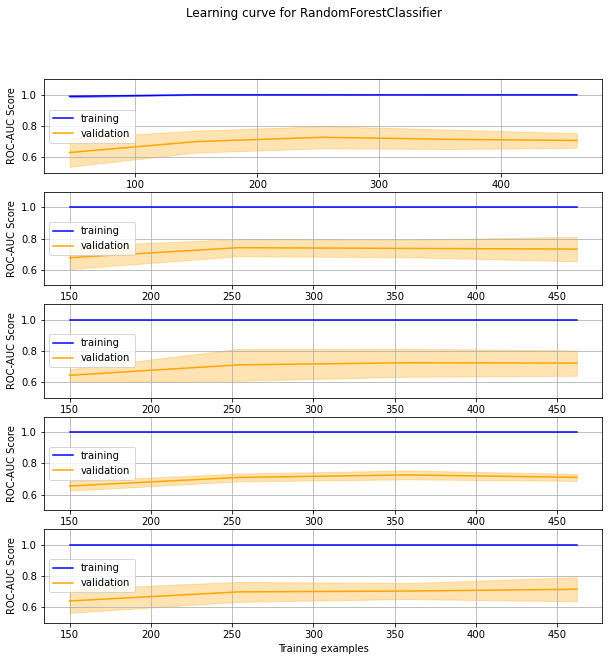

In [7]:
rs = StratifiedShuffleSplit(n_splits=N_SPLITS, test_size=.3, random_state=RANDOM_SEED)

scores_rf = {'f1': [], 'accuracy': [], 'AUC': []}
fitted_clf_list_rf = []

fig, axs = plt.subplots(N_SPLITS, figsize=(10, 10))

for i, (train_index, test_index) in enumerate(rs.split(X, y)):

    # Data split
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_test = X.iloc[test_index]
    y_test = y[test_index]

    # Preprocessing
    scaler = StandardScaler()
    random_forest = RandomForestClassifier()
    pca = PCA()

    # Pipeline
    pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ("random_forest", random_forest)])

    # GridSearch

    # Random grid:
    pca_components = [None] + list(np.arange(1, 101, 20))
    n_estimators = [int(x) for x in np.linspace(start=50, stop=200)]
    max_features = ['auto', 'sqrt', 'log2', 0.1]
    max_depth = [int(x) for x in np.linspace(10, 120, num = 12)]
    min_samples_leaf = [1, 3, 5]
    bootstrap = [True, False]

    random_grid = {'random_forest__n_estimators': n_estimators,
    'random_forest__max_features': max_features,
    'random_forest__max_depth': max_depth,
    'random_forest__min_samples_leaf': min_samples_leaf,
    'random_forest__bootstrap': bootstrap,
    'pca__n_components': pca_components}
 
    search = RandomizedSearchCV(pipe, random_grid, cv=3, scoring = 'f1', verbose=2, n_iter=20, random_state=RANDOM_SEED)
    search.fit(X_train, y_train)
    best_clf = search.best_estimator_
    fitted_clf_list_rf.append(search)


    # Evaluation
    y_pred = best_clf.predict(X_test)
    y_score = best_clf.predict_proba(X_test)
    scores_rf['f1'] += [f1_score(y_test, y_pred)]
    scores_rf['accuracy'] += [accuracy_score(y_test, y_pred)]
    scores_rf['AUC'] += [roc_auc_score(y_test, y_score[:,1])]

    # Predictions
    scores_rf[f'probs_split_{i+1}'] = y_score
    scores_rf[f'labels_split_{i+1}'] = list(y_test)
    
    plot_learning_curve(best_clf, X_train, y_train, axs[i])
    fig.suptitle(f'Learning curve for {str(type(best_clf[-1])).split(".")[-1][:-2]}')
plt.show()

### Results - Overall metrics

In [8]:
print('F1-scores:')
print(f"{scores_rf['f1']}, mean: {np.mean(scores_rf['f1'])}")
print('Accuracy:')
print(f"{scores_rf['accuracy']}, mean: {np.mean(scores_rf['accuracy'])}")
print('AUC:')
print(f"{scores_rf['AUC']}, mean: {np.mean(scores_rf['AUC'])}")

F1-scores:
[0.22641509433962262, 0.37931034482758624, 0.22222222222222218, 0.2711864406779661, 0.14814814814814814], mean: 0.24945645004310907
Accuracy:
[0.8353413654618473, 0.8554216867469879, 0.8313253012048193, 0.8273092369477911, 0.8152610441767069], mean: 0.8329317269076306
AUC:
[0.6296008869179601, 0.7146341463414634, 0.6991130820399113, 0.6781042128603103, 0.6636363636363637], mean: 0.6770177383592018


### Results - Hyperparameter search

In [9]:
import pandas as pd
for i, clf in enumerate(fitted_clf_list_rf): 
    print(f'Results for split {i+1}:')
    param_df = pd.DataFrame(clf.cv_results_)

    # columns to drop from dataframe:
    param_df = param_df.drop(['std_fit_time', 'mean_score_time', 'std_score_time'], axis=1)
    cols = [c for c in param_df.columns if c.lower()[:5] != 'split']
    
    param_df = param_df[cols].sort_values(by='rank_test_score')
    display(param_df.head(5))

Results for split 1:


,mean_fit_time,param_random_forest__n_estimators,param_random_forest__min_samples_leaf,param_random_forest__max_features,param_random_forest__max_depth,param_random_forest__bootstrap,param_pca__n_components,params,mean_test_score,std_test_score,rank_test_score
10,0.751214,172,5,sqrt,90,False,21,"{'random_forest__n_estimators': 172, 'random_f...",0.332205,0.058662,1
5,1.356262,160,1,sqrt,60,False,81,"{'random_forest__n_estimators': 160, 'random_f...",0.321180,0.062684,2
11,0.829527,114,1,auto,50,False,61,"{'random_forest__n_estimators': 114, 'random_f...",0.317756,0.056890,3
7,0.784713,144,1,log2,20,True,41,"{'random_forest__n_estimators': 144, 'random_f...",0.315149,0.085112,4
17,0.825811,108,1,sqrt,60,False,61,"{'random_forest__n_estimators': 108, 'random_f...",0.311764,0.083327,5


Results for split 2:


,mean_fit_time,param_random_forest__n_estimators,param_random_forest__min_samples_leaf,param_random_forest__max_features,param_random_forest__max_depth,param_random_forest__bootstrap,param_pca__n_components,params,mean_test_score,std_test_score,rank_test_score
17,0.812927,108,1,sqrt,60,False,61,"{'random_forest__n_estimators': 108, 'random_f...",0.282205,0.097968,1
19,0.666599,62,1,log2,70,False,81,"{'random_forest__n_estimators': 62, 'random_fo...",0.259280,0.134675,2
5,1.255131,160,1,sqrt,60,False,81,"{'random_forest__n_estimators': 160, 'random_f...",0.250340,0.114010,3
11,0.882937,114,1,auto,50,False,61,"{'random_forest__n_estimators': 114, 'random_f...",0.236667,0.089567,4
12,0.782242,111,1,auto,10,False,61,"{'random_forest__n_estimators': 111, 'random_f...",0.229262,0.068076,5


Results for split 3:


,mean_fit_time,param_random_forest__n_estimators,param_random_forest__min_samples_leaf,param_random_forest__max_features,param_random_forest__max_depth,param_random_forest__bootstrap,param_pca__n_components,params,mean_test_score,std_test_score,rank_test_score
5,1.207737,160,1,sqrt,60,False,81,"{'random_forest__n_estimators': 160, 'random_f...",0.353550,0.083107,1
11,0.814531,114,1,auto,50,False,61,"{'random_forest__n_estimators': 114, 'random_f...",0.321716,0.101822,2
17,0.839419,108,1,sqrt,60,False,61,"{'random_forest__n_estimators': 108, 'random_f...",0.281878,0.057860,3
7,0.705875,144,1,log2,20,True,41,"{'random_forest__n_estimators': 144, 'random_f...",0.281301,0.085825,4
12,0.747160,111,1,auto,10,False,61,"{'random_forest__n_estimators': 111, 'random_f...",0.259778,0.116762,5


Results for split 4:


,mean_fit_time,param_random_forest__n_estimators,param_random_forest__min_samples_leaf,param_random_forest__max_features,param_random_forest__max_depth,param_random_forest__bootstrap,param_pca__n_components,params,mean_test_score,std_test_score,rank_test_score
17,0.837775,108,1,sqrt,60,False,61,"{'random_forest__n_estimators': 108, 'random_f...",0.338899,0.037638,1
10,0.761087,172,5,sqrt,90,False,21,"{'random_forest__n_estimators': 172, 'random_f...",0.334742,0.158423,2
12,0.743390,111,1,auto,10,False,61,"{'random_forest__n_estimators': 111, 'random_f...",0.333660,0.129965,3
11,0.797861,114,1,auto,50,False,61,"{'random_forest__n_estimators': 114, 'random_f...",0.319480,0.072167,4
5,1.185240,160,1,sqrt,60,False,81,"{'random_forest__n_estimators': 160, 'random_f...",0.317884,0.056448,5


Results for split 5:


,mean_fit_time,param_random_forest__n_estimators,param_random_forest__min_samples_leaf,param_random_forest__max_features,param_random_forest__max_depth,param_random_forest__bootstrap,param_pca__n_components,params,mean_test_score,std_test_score,rank_test_score
11,0.843405,114,1,auto,50,False,61,"{'random_forest__n_estimators': 114, 'random_f...",0.267939,0.087705,1
5,1.104190,160,1,sqrt,60,False,81,"{'random_forest__n_estimators': 160, 'random_f...",0.241397,0.034807,2
2,0.764424,111,1,auto,90,True,81,"{'random_forest__n_estimators': 111, 'random_f...",0.218496,0.015572,3
7,0.710474,144,1,log2,20,True,41,"{'random_forest__n_estimators': 144, 'random_f...",0.216931,0.019797,4
10,0.773503,172,5,sqrt,90,False,21,"{'random_forest__n_estimators': 172, 'random_f...",0.215171,0.057279,5


# Naive Bayes

#### Training-Testing using k-best feature selection

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END nbayes__var_smoothing=3.511191734215127e-05, select__k=20; total time=   0.3s
[CV] END nbayes__var_smoothing=3.511191734215127e-05, select__k=20; total time=   0.2s
[CV] END nbayes__var_smoothing=3.511191734215127e-05, select__k=20; total time=   0.2s
[CV] END nbayes__var_smoothing=0.3511191734215131, select__k=122; total time=   0.2s
[CV] END nbayes__var_smoothing=0.3511191734215131, select__k=122; total time=   0.2s
[CV] END nbayes__var_smoothing=0.3511191734215131, select__k=122; total time=   0.3s
[CV] END nbayes__var_smoothing=0.0005336699231206307, select__k=64; total time=   0.2s
[CV] END nbayes__var_smoothing=0.0005336699231206307, select__k=64; total time=   0.2s
[CV] END nbayes__var_smoothing=0.0005336699231206307, select__k=64; total time=   0.2s
[CV] END nbayes__var_smoothing=6.579332246575682e-09, select__k=100; total time=   0.2s
[CV] END nbayes__var_smoothing=6.579332246575682e-09, select__k=100; total

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    8.3s finished


[CV] END nbayes__var_smoothing=3.511191734215127e-05, select__k=20; total time=   0.2s
[CV] END nbayes__var_smoothing=3.511191734215127e-05, select__k=20; total time=   0.2s
[CV] END nbayes__var_smoothing=3.511191734215127e-05, select__k=20; total time=   0.2s
[CV] END nbayes__var_smoothing=0.3511191734215131, select__k=122; total time=   0.3s
[CV] END nbayes__var_smoothing=0.3511191734215131, select__k=122; total time=   0.2s
[CV] END nbayes__var_smoothing=0.3511191734215131, select__k=122; total time=   0.2s
[CV] END nbayes__var_smoothing=0.0005336699231206307, select__k=64; total time=   0.2s
[CV] END nbayes__var_smoothing=0.0005336699231206307, select__k=64; total time=   0.2s
[CV] END nbayes__var_smoothing=0.0005336699231206307, select__k=64; total time=   0.2s
[CV] END nbayes__var_smoothing=6.579332246575682e-09, select__k=100; total time=   0.2s
[CV] END nbayes__var_smoothing=6.579332246575682e-09, select__k=100; total time=   0.2s
[CV] END nbayes__var_smoothing=6.57933224657568

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.1s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    7.7s finished


[CV] END nbayes__var_smoothing=3.511191734215127e-05, select__k=20; total time=   0.2s
[CV] END nbayes__var_smoothing=3.511191734215127e-05, select__k=20; total time=   0.2s
[CV] END nbayes__var_smoothing=3.511191734215127e-05, select__k=20; total time=   0.2s
[CV] END nbayes__var_smoothing=0.3511191734215131, select__k=122; total time=   0.2s
[CV] END nbayes__var_smoothing=0.3511191734215131, select__k=122; total time=   0.2s
[CV] END nbayes__var_smoothing=0.3511191734215131, select__k=122; total time=   0.2s
[CV] END nbayes__var_smoothing=0.0005336699231206307, select__k=64; total time=   0.2s
[CV] END nbayes__var_smoothing=0.0005336699231206307, select__k=64; total time=   0.2s
[CV] END nbayes__var_smoothing=0.0005336699231206307, select__k=64; total time=   0.2s
[CV] END nbayes__var_smoothing=6.579332246575682e-09, select__k=100; total time=   0.2s
[CV] END nbayes__var_smoothing=6.579332246575682e-09, select__k=100; total time=   0.3s
[CV] END nbayes__var_smoothing=6.57933224657568

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    8.1s finished


[CV] END nbayes__var_smoothing=3.511191734215127e-05, select__k=20; total time=   0.2s
[CV] END nbayes__var_smoothing=3.511191734215127e-05, select__k=20; total time=   0.2s
[CV] END nbayes__var_smoothing=3.511191734215127e-05, select__k=20; total time=   0.2s
[CV] END nbayes__var_smoothing=0.3511191734215131, select__k=122; total time=   0.2s
[CV] END nbayes__var_smoothing=0.3511191734215131, select__k=122; total time=   0.2s
[CV] END nbayes__var_smoothing=0.3511191734215131, select__k=122; total time=   0.2s
[CV] END nbayes__var_smoothing=0.0005336699231206307, select__k=64; total time=   0.2s
[CV] END nbayes__var_smoothing=0.0005336699231206307, select__k=64; total time=   0.2s
[CV] END nbayes__var_smoothing=0.0005336699231206307, select__k=64; total time=   0.2s
[CV] END nbayes__var_smoothing=6.579332246575682e-09, select__k=100; total time=   0.2s
[CV] END nbayes__var_smoothing=6.579332246575682e-09, select__k=100; total time=   0.2s
[CV] END nbayes__var_smoothing=6.57933224657568

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    8.3s finished


[CV] END nbayes__var_smoothing=3.511191734215127e-05, select__k=20; total time=   0.3s
[CV] END nbayes__var_smoothing=3.511191734215127e-05, select__k=20; total time=   0.3s
[CV] END nbayes__var_smoothing=3.511191734215127e-05, select__k=20; total time=   0.2s
[CV] END nbayes__var_smoothing=0.3511191734215131, select__k=122; total time=   0.3s
[CV] END nbayes__var_smoothing=0.3511191734215131, select__k=122; total time=   0.2s
[CV] END nbayes__var_smoothing=0.3511191734215131, select__k=122; total time=   0.3s
[CV] END nbayes__var_smoothing=0.0005336699231206307, select__k=64; total time=   0.2s
[CV] END nbayes__var_smoothing=0.0005336699231206307, select__k=64; total time=   0.2s
[CV] END nbayes__var_smoothing=0.0005336699231206307, select__k=64; total time=   0.2s
[CV] END nbayes__var_smoothing=6.579332246575682e-09, select__k=100; total time=   0.2s
[CV] END nbayes__var_smoothing=6.579332246575682e-09, select__k=100; total time=   0.2s
[CV] END nbayes__var_smoothing=6.57933224657568

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    8.2s finished


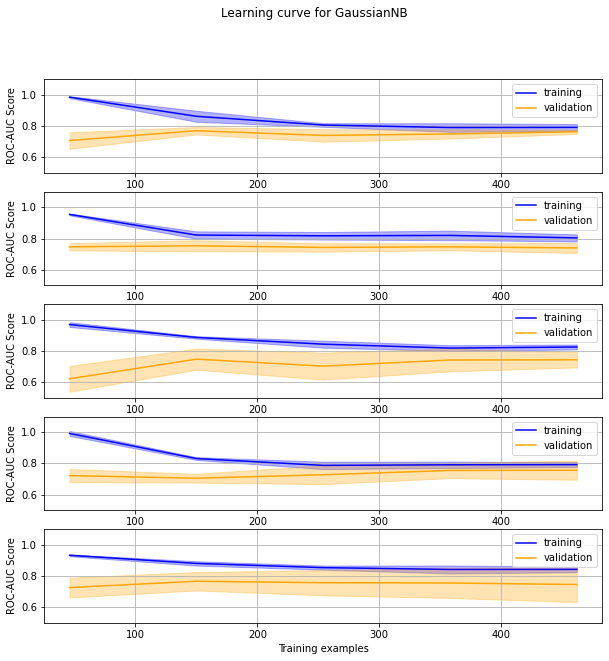

In [10]:
rs = StratifiedShuffleSplit(n_splits=N_SPLITS, test_size=.3, random_state=RANDOM_SEED)

scores_nb = {'f1': [], 'accuracy': [], 'AUC': []}
fitted_clf_list_nb = []

fig, axs = plt.subplots(N_SPLITS, figsize=(10, 10))

for i, (train_index, test_index) in enumerate(rs.split(X, y)):

    # Data split
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_test = X.iloc[test_index]
    y_test = y[test_index]

    # Preprocessing
    scaler = StandardScaler()
    naive_bayes = GaussianNB()
    pca = PCA()
    selector = SelectKBest()

    # Pipeline
    pipe = Pipeline(steps=[('select', selector), ("nbayes", naive_bayes)])

    # Random grid:
    pca_components = [None] + list(np.arange(1, 101, 20))
    var_smoothing = np.logspace(0,-9, num=100)
    k_select = np.arange(2, 150)

    random_grid = {'nbayes__var_smoothing': var_smoothing,
    #'pca__n_components': pca_components}
    'select__k': k_select}

    search = RandomizedSearchCV(pipe, random_grid, cv=3, scoring = 'f1', verbose=2, n_iter= 20, random_state=RANDOM_SEED)
    search.fit(X_train, y_train)
    best_clf = search.best_estimator_
    fitted_clf_list_nb.append(search)

    # Evaluation
    y_pred = best_clf.predict(X_test)
    y_score = best_clf.predict_proba(X_test)
    scores_nb['f1'] += [f1_score(y_test, y_pred)]
    scores_nb['accuracy'] += [accuracy_score(y_test, y_pred)]
    scores_nb['AUC'] += [roc_auc_score(y_test, y_score[:,1])]

    # Predictions
    scores_nb[f'probs_split_{i+1}'] = y_score
    scores_nb[f'labels_split_{i+1}'] = list(y_test)
    
    plot_learning_curve(best_clf, X_train, y_train, axs[i])
    fig.suptitle(f'Learning curve for {str(type(best_clf[-1])).split(".")[-1][:-2]}')
plt.show()

#### Training-Testing using Standard Scaler and PCA (hidden)
Performance for this pipeline was less compared to using the k-best feature selection (above).

In [ ]:
rs = StratifiedShuffleSplit(n_splits=N_SPLITS, test_size=.3, random_state=RANDOM_SEED)

scores_nb = {'f1': [], 'accuracy': [], 'AUC': []}
fitted_clf_list_nb = []

fig, axs = plt.subplots(N_SPLITS, figsize=(10, 10))

for i, (train_index, test_index) in enumerate(rs.split(X, y)):

    # Data split
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_test = X.iloc[test_index]
    y_test = y[test_index]

    # Preprocessing
    scaler = StandardScaler()
    naive_bayes = GaussianNB()
    pca = PCA()

    # Pipeline
    pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ("nbayes", naive_bayes)])

    # Random grid:
    pca_components = [None] + list(np.arange(1, 101, 20))
    var_smoothing = np.logspace(0,-9, num=100)
    k_select = np.arange(2, 150)

    random_grid = {'nbayes__var_smoothing': var_smoothing,
    #'pca__n_components': pca_components}
    'select__k': k_select}

    search = RandomizedSearchCV(pipe, random_grid, cv=3, scoring = 'f1', verbose=2, n_iter= 20, random_state=RANDOM_SEED)
    search.fit(X_train, y_train)
    best_clf = search.best_estimator_
    fitted_clf_list_nb.append(search)

    # Evaluation
    y_pred = best_clf.predict(X_test)
    scores_nb['f1'] += [f1_score(y_test, y_pred)]
    scores_nb['accuracy'] += [accuracy_score(y_test, y_pred)]
    scores_nb['AUC'] += [roc_auc_score(y_test, y_pred)]
    
    plot_learning_curve(best_clf, X_train, y_train, axs[i])
    fig.suptitle(f'Learning curve for {str(type(best_clf[-1])).split(".")[-1][:-2]}')
plt.show()

### Results - Overall metrics

In [11]:
print('F1-scores:')
print(f"{scores_nb['f1']}, mean: {np.mean(scores_nb['f1'])}")
print('Accuracy:')
print(f"{scores_nb['accuracy']}, mean: {np.mean(scores_nb['accuracy'])}")
print('AUC:')
print(f"{scores_nb['AUC']}, mean: {np.mean(scores_nb['AUC'])}")

F1-scores:
[0.29333333333333333, 0.39473684210526316, 0.3384615384615385, 0.44444444444444453, 0.3835616438356164], mean: 0.3709075604360392
Accuracy:
[0.7871485943775101, 0.8152610441767069, 0.8273092369477911, 0.8192771084337349, 0.8192771084337349], mean: 0.8136546184738955
AUC:
[0.7232815964523281, 0.751330376940133, 0.7454545454545455, 0.7532150776053215, 0.7568181818181818], mean: 0.7460199556541021


### Results - Hyperparameter search

In [12]:
import pandas as pd
for i, clf in enumerate(fitted_clf_list_nb): 
    print(f'Results for split {i+1}:')
    param_df = pd.DataFrame(clf.cv_results_)

    # columns to drop from dataframe:
    param_df = param_df.drop(['std_fit_time', 'mean_score_time', 'std_score_time'], axis=1)
    cols = [c for c in param_df.columns if c.lower()[:5] != 'split']
    
    param_df = param_df[cols].sort_values(by='rank_test_score')
    display(param_df.head(5))

Results for split 1:


,mean_fit_time,param_select__k,param_nbayes__var_smoothing,params,mean_test_score,std_test_score,rank_test_score
6,0.228263,38,0.0,"{'select__k': 38, 'nbayes__var_smoothing': 1.2...",0.541202,0.025172,1
17,0.214028,36,0.000008,"{'select__k': 36, 'nbayes__var_smoothing': 8.1...",0.541179,0.039229,2
0,0.267882,20,0.000035,"{'select__k': 20, 'nbayes__var_smoothing': 3.5...",0.539254,0.028365,3
2,0.224989,64,0.000534,"{'select__k': 64, 'nbayes__var_smoothing': 0.0...",0.524095,0.059085,4
8,0.253275,51,0.000152,"{'select__k': 51, 'nbayes__var_smoothing': 0.0...",0.518381,0.044970,5


Results for split 2:


,mean_fit_time,param_select__k,param_nbayes__var_smoothing,params,mean_test_score,std_test_score,rank_test_score
0,0.211126,20,0.000035,"{'select__k': 20, 'nbayes__var_smoothing': 3.5...",0.459360,0.035366,1
6,0.253914,38,0.0,"{'select__k': 38, 'nbayes__var_smoothing': 1.2...",0.451502,0.041341,2
17,0.227974,36,0.000008,"{'select__k': 36, 'nbayes__var_smoothing': 8.1...",0.449402,0.035270,3
8,0.225798,51,0.000152,"{'select__k': 51, 'nbayes__var_smoothing': 0.0...",0.428523,0.078392,4
4,0.248507,13,0.000658,"{'select__k': 13, 'nbayes__var_smoothing': 0.0...",0.414796,0.038546,5


Results for split 3:


,mean_fit_time,param_select__k,param_nbayes__var_smoothing,params,mean_test_score,std_test_score,rank_test_score
7,0.248114,112,0.000351,"{'select__k': 112, 'nbayes__var_smoothing': 0....",0.432772,0.059804,1
11,0.246401,136,0.00231,"{'select__k': 136, 'nbayes__var_smoothing': 0....",0.427893,0.054070,2
18,0.210916,59,0.1,"{'select__k': 59, 'nbayes__var_smoothing': 0.1}",0.424311,0.094109,3
6,0.265044,38,0.0,"{'select__k': 38, 'nbayes__var_smoothing': 1.2...",0.422056,0.085715,4
12,0.215651,104,0.000433,"{'select__k': 104, 'nbayes__var_smoothing': 0....",0.419885,0.052917,5


Results for split 4:


,mean_fit_time,param_select__k,param_nbayes__var_smoothing,params,mean_test_score,std_test_score,rank_test_score
0,0.256283,20,0.000035,"{'select__k': 20, 'nbayes__var_smoothing': 3.5...",0.478135,0.033292,1
17,0.242209,36,0.000008,"{'select__k': 36, 'nbayes__var_smoothing': 8.1...",0.467754,0.040234,2
6,0.241651,38,0.0,"{'select__k': 38, 'nbayes__var_smoothing': 1.2...",0.460954,0.053988,3
2,0.231730,64,0.000534,"{'select__k': 64, 'nbayes__var_smoothing': 0.0...",0.460561,0.065966,4
12,0.226743,104,0.000433,"{'select__k': 104, 'nbayes__var_smoothing': 0....",0.451122,0.048727,5


Results for split 5:


,mean_fit_time,param_select__k,param_nbayes__var_smoothing,params,mean_test_score,std_test_score,rank_test_score
11,0.221150,136,0.00231,"{'select__k': 136, 'nbayes__var_smoothing': 0....",0.464742,0.050846,1
17,0.247878,36,0.000008,"{'select__k': 36, 'nbayes__var_smoothing': 8.1...",0.458473,0.058353,2
12,0.226262,104,0.000433,"{'select__k': 104, 'nbayes__var_smoothing': 0....",0.456506,0.044669,3
2,0.246080,64,0.000534,"{'select__k': 64, 'nbayes__var_smoothing': 0.0...",0.451254,0.047363,4
7,0.230458,112,0.000351,"{'select__k': 112, 'nbayes__var_smoothing': 0....",0.447581,0.057274,5


# K-Nearest Neighbours

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END knn__n_neighbors=25, knn__weights=distance, select__k=20; total time=   0.2s
[CV] END knn__n_neighbors=25, knn__weights=distance, select__k=20; total time=   0.2s
[CV] END knn__n_neighbors=25, knn__weights=distance, select__k=20; total time=   0.2s
[CV] END knn__n_neighbors=3, knn__weights=distance, select__k=122; total time=   0.2s
[CV] END knn__n_neighbors=3, knn__weights=distance, select__k=122; total time=   0.2s
[CV] END knn__n_neighbors=3, knn__weights=distance, select__k=122; total time=   0.2s
[CV] END knn__n_neighbors=19, knn__weights=uniform, select__k=64; total time=   0.2s
[CV] END knn__n_neighbors=19, knn__weights=uniform, select__k=64; total time=   0.2s
[CV] END knn__n_neighbors=19, knn__weights=uniform, select__k=64; total time=   0.2s
[CV] END knn__n_neighbors=18, knn__weights=distance, select__k=13; total time=   0.3s
[CV] END knn__n_neighbors=18, knn__weights=distance, select__k=13; total time=   0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.1s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    9.1s finished


[CV] END knn__n_neighbors=25, knn__weights=distance, select__k=20; total time=   0.2s
[CV] END knn__n_neighbors=25, knn__weights=distance, select__k=20; total time=   0.2s
[CV] END knn__n_neighbors=25, knn__weights=distance, select__k=20; total time=   0.2s
[CV] END knn__n_neighbors=3, knn__weights=distance, select__k=122; total time=   0.2s
[CV] END knn__n_neighbors=3, knn__weights=distance, select__k=122; total time=   0.2s
[CV] END knn__n_neighbors=3, knn__weights=distance, select__k=122; total time=   0.2s
[CV] END knn__n_neighbors=19, knn__weights=uniform, select__k=64; total time=   0.2s
[CV] END knn__n_neighbors=19, knn__weights=uniform, select__k=64; total time=   0.2s
[CV] END knn__n_neighbors=19, knn__weights=uniform, select__k=64; total time=   0.2s
[CV] END knn__n_neighbors=18, knn__weights=distance, select__k=13; total time=   0.2s
[CV] END knn__n_neighbors=18, knn__weights=distance, select__k=13; total time=   0.2s
[CV] END knn__n_neighbors=18, knn__weights=distance, sele

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    8.7s finished


[CV] END knn__n_neighbors=25, knn__weights=distance, select__k=20; total time=   0.2s
[CV] END knn__n_neighbors=25, knn__weights=distance, select__k=20; total time=   0.2s
[CV] END knn__n_neighbors=25, knn__weights=distance, select__k=20; total time=   0.2s
[CV] END knn__n_neighbors=3, knn__weights=distance, select__k=122; total time=   0.2s
[CV] END knn__n_neighbors=3, knn__weights=distance, select__k=122; total time=   0.2s
[CV] END knn__n_neighbors=3, knn__weights=distance, select__k=122; total time=   0.2s
[CV] END knn__n_neighbors=19, knn__weights=uniform, select__k=64; total time=   0.2s
[CV] END knn__n_neighbors=19, knn__weights=uniform, select__k=64; total time=   0.2s
[CV] END knn__n_neighbors=19, knn__weights=uniform, select__k=64; total time=   0.2s
[CV] END knn__n_neighbors=18, knn__weights=distance, select__k=13; total time=   0.2s
[CV] END knn__n_neighbors=18, knn__weights=distance, select__k=13; total time=   0.2s
[CV] END knn__n_neighbors=18, knn__weights=distance, sele

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    8.8s finished


[CV] END knn__n_neighbors=25, knn__weights=distance, select__k=20; total time=   0.2s
[CV] END knn__n_neighbors=25, knn__weights=distance, select__k=20; total time=   0.2s
[CV] END knn__n_neighbors=25, knn__weights=distance, select__k=20; total time=   0.2s
[CV] END knn__n_neighbors=3, knn__weights=distance, select__k=122; total time=   0.2s
[CV] END knn__n_neighbors=3, knn__weights=distance, select__k=122; total time=   0.2s
[CV] END knn__n_neighbors=3, knn__weights=distance, select__k=122; total time=   0.3s
[CV] END knn__n_neighbors=19, knn__weights=uniform, select__k=64; total time=   0.2s
[CV] END knn__n_neighbors=19, knn__weights=uniform, select__k=64; total time=   0.3s
[CV] END knn__n_neighbors=19, knn__weights=uniform, select__k=64; total time=   0.2s
[CV] END knn__n_neighbors=18, knn__weights=distance, select__k=13; total time=   0.3s
[CV] END knn__n_neighbors=18, knn__weights=distance, select__k=13; total time=   0.2s
[CV] END knn__n_neighbors=18, knn__weights=distance, sele

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    9.5s finished


[CV] END knn__n_neighbors=25, knn__weights=distance, select__k=20; total time=   0.3s
[CV] END knn__n_neighbors=25, knn__weights=distance, select__k=20; total time=   0.2s
[CV] END knn__n_neighbors=25, knn__weights=distance, select__k=20; total time=   0.4s
[CV] END knn__n_neighbors=3, knn__weights=distance, select__k=122; total time=   0.2s
[CV] END knn__n_neighbors=3, knn__weights=distance, select__k=122; total time=   0.2s
[CV] END knn__n_neighbors=3, knn__weights=distance, select__k=122; total time=   0.3s
[CV] END knn__n_neighbors=19, knn__weights=uniform, select__k=64; total time=   0.2s
[CV] END knn__n_neighbors=19, knn__weights=uniform, select__k=64; total time=   0.2s
[CV] END knn__n_neighbors=19, knn__weights=uniform, select__k=64; total time=   0.3s
[CV] END knn__n_neighbors=18, knn__weights=distance, select__k=13; total time=   0.2s
[CV] END knn__n_neighbors=18, knn__weights=distance, select__k=13; total time=   0.2s
[CV] END knn__n_neighbors=18, knn__weights=distance, sele

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    8.0s finished


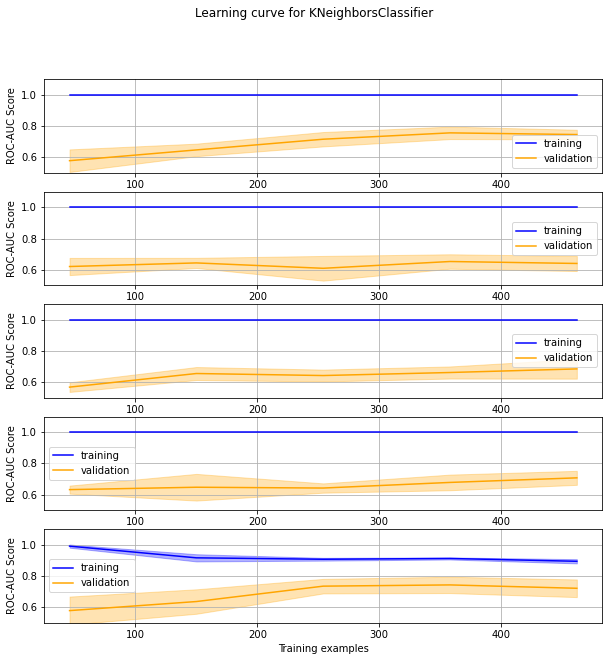

In [13]:
rs = StratifiedShuffleSplit(n_splits=N_SPLITS, test_size=.3, random_state=RANDOM_SEED)

scores_knn = {'f1': [], 'accuracy': [], 'AUC': []}
fitted_clf_list_knn = []

fig, axs = plt.subplots(N_SPLITS, figsize=(10, 10))

for i, (train_index, test_index) in enumerate(rs.split(X, y)):

    # Data split
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_test = X.iloc[test_index]
    y_test = y[test_index]

    # Preprocessing
    scaler = StandardScaler()
    knn = KNeighborsClassifier()
    pca = PCA()
    selector = SelectKBest()

    # Pipeline
    pipe = Pipeline(steps=[('select', selector), ("knn", knn)])

    # Random grid:
    pca_components = [None] + list(np.arange(1, 101, 20))
    k_range = list(range(1, 31))
    weights = ['uniform', 'distance']
    k_select = np.arange(2, 150)

    random_grid = {'knn__n_neighbors': k_range,
    'knn__weights': weights,
    #'pca__n_components': pca_components}
    'select__k': k_select}

    # Hoeveel iteraties willen we?
    search = RandomizedSearchCV(pipe, random_grid, cv=3, scoring = 'f1', verbose=2, n_iter=20, random_state=RANDOM_SEED)
    search.fit(X_train, y_train)
    best_clf = search.best_estimator_
    fitted_clf_list_knn.append(search)
    
    # evaluation
    y_pred = best_clf.predict(X_test)
    y_score = best_clf.predict_proba(X_test)
    scores_knn['f1'] += [f1_score(y_test, y_pred)]
    scores_knn['accuracy'] += [accuracy_score(y_test, y_pred)]
    scores_knn['AUC'] += [roc_auc_score(y_test, y_score[:,1])]
    
    # Predictions
    scores_knn[f'probs_split_{i+1}'] = y_score
    scores_knn[f'labels_split_{i+1}'] = list(y_test)

    plot_learning_curve(best_clf, X_train, y_train, axs[i]) # eventueel testen met groot aantal neighbors
    fig.suptitle(f'Learning curve for {str(type(best_clf[-1])).split(".")[-1][:-2]}')
plt.show()

In [ ]:
rs = StratifiedShuffleSplit(n_splits=N_SPLITS, test_size=.3, random_state=RANDOM_SEED)

scores_knn = {'f1': [], 'accuracy': [], 'AUC': []}
fitted_clf_list_knn = []

fig, axs = plt.subplots(N_SPLITS, figsize=(10, 10))

for i, (train_index, test_index) in enumerate(rs.split(X, y)):

    # Data split
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_test = X.iloc[test_index]
    y_test = y[test_index]

    # Preprocessing
    scaler = StandardScaler()
    knn = KNeighborsClassifier()
    pca = PCA()
    selector = SelectKBest()

    # Pipeline
    pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ("knn", knn)])

    # GridSearch

    # Random grid:
    pca_components = [None] + list(np.arange(1, 101, 20))
    k_range = list(range(1, 31))
    weights = ['uniform', 'distance']
    k_select = np.arange(2, 150)

    random_grid = {'knn__n_neighbors': k_range,
    'knn__weights': weights,
    'pca__n_components': pca_components}
    #'select__k': k_select}

    # Hoeveel iteraties willen we?
    search = RandomizedSearchCV(pipe, random_grid, cv=3, scoring = 'f1', verbose=2, n_iter=20, random_state=RANDOM_SEED)
    search.fit(X_train, y_train)
    best_clf = search.best_estimator_
    fitted_clf_list_knn.append(search)
    
    # evaluation
    y_pred = best_clf.predict(X_test)
    scores_knn['f1'] += [f1_score(y_test, y_pred)]
    scores_knn['accuracy'] += [accuracy_score(y_test, y_pred)]
    scores_knn['AUC'] += [roc_auc_score(y_test, y_pred)]
    
    plot_learning_curve(best_clf, X_train, y_train, axs[i]) # eventueel testen met groot aantal neighbors
    fig.suptitle(f'Learning curve for {str(type(best_clf[-1])).split(".")[-1][:-2]}')
plt.show()

### Results - Overall metrics

In [14]:
print('F1-scores:')
print(f"{scores_knn['f1']}, mean: {np.mean(scores_knn['f1'])}")
print('Accuracy:')
print(f"{scores_knn['accuracy']}, mean: {np.mean(scores_knn['accuracy'])}")
print('AUC:')
print(f"{scores_knn['AUC']}, mean: {np.mean(scores_knn['AUC'])}")

F1-scores:
[0.3, 0.3157894736842105, 0.30508474576271183, 0.3333333333333333, 0.2857142857142857], mean: 0.3079843676989083
Accuracy:
[0.8313253012048193, 0.7911646586345381, 0.8353413654618473, 0.8232931726907631, 0.7991967871485943], mean: 0.8160642570281125
AUC:
[0.698059866962306, 0.6273835920177384, 0.6866962305986697, 0.6746674057649669, 0.6253880266075388], mean: 0.662439024390244


### Results - Hyperparameter search

In [15]:
import pandas as pd
for i, clf in enumerate(fitted_clf_list_knn): 
    print(f'Results for split {i+1}:')
    param_df = pd.DataFrame(clf.cv_results_)

    # columns to drop from dataframe:
    param_df = param_df.drop(['std_fit_time', 'mean_score_time', 'std_score_time'], axis=1)
    cols = [c for c in param_df.columns if c.lower()[:5] != 'split']
    
    param_df = param_df[cols].sort_values(by='rank_test_score')
    display(param_df.head(5))

Results for split 1:


,mean_fit_time,param_select__k,param_knn__weights,param_knn__n_neighbors,params,mean_test_score,std_test_score,rank_test_score
1,0.239149,122,distance,3,"{'select__k': 122, 'knn__weights': 'distance',...",0.399622,0.047244,1
6,0.280544,24,distance,2,"{'select__k': 24, 'knn__weights': 'distance', ...",0.391728,0.037842,2
10,0.226379,59,distance,6,"{'select__k': 59, 'knn__weights': 'distance', ...",0.375982,0.047952,3
11,0.251357,31,distance,3,"{'select__k': 31, 'knn__weights': 'distance', ...",0.348874,0.066249,4
17,0.251126,2,uniform,5,"{'select__k': 2, 'knn__weights': 'uniform', 'k...",0.335297,0.084699,5


Results for split 2:


,mean_fit_time,param_select__k,param_knn__weights,param_knn__n_neighbors,params,mean_test_score,std_test_score,rank_test_score
6,0.285085,24,distance,2,"{'select__k': 24, 'knn__weights': 'distance', ...",0.358886,0.015798,1
11,0.244707,31,distance,3,"{'select__k': 31, 'knn__weights': 'distance', ...",0.313642,0.040591,2
1,0.236246,122,distance,3,"{'select__k': 122, 'knn__weights': 'distance',...",0.307121,0.063629,3
17,0.225965,2,uniform,5,"{'select__k': 2, 'knn__weights': 'uniform', 'k...",0.268908,0.029896,4
10,0.259370,59,distance,6,"{'select__k': 59, 'knn__weights': 'distance', ...",0.228801,0.090628,5


Results for split 3:


,mean_fit_time,param_select__k,param_knn__weights,param_knn__n_neighbors,params,mean_test_score,std_test_score,rank_test_score
1,0.240004,122,distance,3,"{'select__k': 122, 'knn__weights': 'distance',...",0.317734,0.093380,1
17,0.226261,2,uniform,5,"{'select__k': 2, 'knn__weights': 'uniform', 'k...",0.303801,0.048680,2
11,0.256661,31,distance,3,"{'select__k': 31, 'knn__weights': 'distance', ...",0.267177,0.119857,3
10,0.221721,59,distance,6,"{'select__k': 59, 'knn__weights': 'distance', ...",0.265179,0.115200,4
6,0.247930,24,distance,2,"{'select__k': 24, 'knn__weights': 'distance', ...",0.251555,0.051310,5


Results for split 4:


,mean_fit_time,param_select__k,param_knn__weights,param_knn__n_neighbors,params,mean_test_score,std_test_score,rank_test_score
6,0.242361,24,distance,2,"{'select__k': 24, 'knn__weights': 'distance', ...",0.439980,0.015346,1
17,0.237759,2,uniform,5,"{'select__k': 2, 'knn__weights': 'uniform', 'k...",0.359046,0.055829,2
11,0.230876,31,distance,3,"{'select__k': 31, 'knn__weights': 'distance', ...",0.347764,0.101020,3
1,0.278980,122,distance,3,"{'select__k': 122, 'knn__weights': 'distance',...",0.332205,0.058662,4
10,0.232539,59,distance,6,"{'select__k': 59, 'knn__weights': 'distance', ...",0.276251,0.072528,5


Results for split 5:


,mean_fit_time,param_select__k,param_knn__weights,param_knn__n_neighbors,params,mean_test_score,std_test_score,rank_test_score
17,0.235398,2,uniform,5,"{'select__k': 2, 'knn__weights': 'uniform', 'k...",0.381292,0.037926,1
11,0.263348,31,distance,3,"{'select__k': 31, 'knn__weights': 'distance', ...",0.376805,0.021247,2
6,0.239793,24,distance,2,"{'select__k': 24, 'knn__weights': 'distance', ...",0.358397,0.047840,3
1,0.250012,122,distance,3,"{'select__k': 122, 'knn__weights': 'distance',...",0.300541,0.081360,4
10,0.269762,59,distance,6,"{'select__k': 59, 'knn__weights': 'distance', ...",0.294671,0.051838,5


# SVM

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3] END select__k=161, svm__C=40.01, svm__gamma=0.8510000000000001, svm__kernel=poly;, score=0.385 total time=   0.4s
[CV 2/3] END select__k=161, svm__C=40.01, svm__gamma=0.8510000000000001, svm__kernel=poly;, score=0.311 total time=   0.3s
[CV 3/3] END select__k=161, svm__C=40.01, svm__gamma=0.8510000000000001, svm__kernel=poly;, score=0.419 total time=   0.4s
[CV 1/3] END select__k=155, svm__C=85.01, svm__gamma=0.9510000000000001, svm__kernel=linear;, score=0.474 total time=   0.4s
[CV 2/3] END select__k=155, svm__C=85.01, svm__gamma=0.9510000000000001, svm__kernel=linear;, score=0.312 total time=   0.5s
[CV 3/3] END select__k=155, svm__C=85.01, svm__gamma=0.9510000000000001, svm__kernel=linear;, score=0.316 total time=   0.4s
[CV 1/3] END select__k=141, svm__C=10.01, svm__gamma=0.9510000000000001, svm__kernel=rbf;, score=0.000 total time=   0.4s
[CV 2/3] END select__k=141, svm__C=10.01, svm__gamma=0.9510000000000001, 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   1.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   15.7s finished


[CV 1/3] END select__k=163, svm__C=90.01, svm__gamma=0.8510000000000001, svm__kernel=poly;, score=0.462 total time=   0.3s
[CV 2/3] END select__k=163, svm__C=90.01, svm__gamma=0.8510000000000001, svm__kernel=poly;, score=0.333 total time=   0.3s
[CV 3/3] END select__k=163, svm__C=90.01, svm__gamma=0.8510000000000001, svm__kernel=poly;, score=0.423 total time=   0.4s
[CV 1/3] END select__k=152, svm__C=90.01, svm__gamma=0.751, svm__kernel=poly;, score=0.462 total time=   0.3s
[CV 2/3] END select__k=152, svm__C=90.01, svm__gamma=0.751, svm__kernel=poly;, score=0.340 total time=   0.3s
[CV 3/3] END select__k=152, svm__C=90.01, svm__gamma=0.751, svm__kernel=poly;, score=0.453 total time=   0.3s
[CV 1/3] END select__k=145, svm__C=20.01, svm__gamma=0.6010000000000001, svm__kernel=poly;, score=0.462 total time=   0.3s
[CV 2/3] END select__k=145, svm__C=20.01, svm__gamma=0.6010000000000001, svm__kernel=poly;, score=0.327 total time=   0.3s
[CV 3/3] END select__k=145, svm__C=20.01, svm__gamma=0.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   10.2s finished


[CV 1/3] END select__k=185, svm__C=65.01, svm__gamma=0.7010000000000001, svm__kernel=rbf;, score=0.000 total time=   0.4s
[CV 2/3] END select__k=185, svm__C=65.01, svm__gamma=0.7010000000000001, svm__kernel=rbf;, score=0.000 total time=   0.3s
[CV 3/3] END select__k=185, svm__C=65.01, svm__gamma=0.7010000000000001, svm__kernel=rbf;, score=0.000 total time=   0.4s
[CV 1/3] END select__k=160, svm__C=80.01, svm__gamma=0.7010000000000001, svm__kernel=rbf;, score=0.000 total time=   0.3s
[CV 2/3] END select__k=160, svm__C=80.01, svm__gamma=0.7010000000000001, svm__kernel=rbf;, score=0.000 total time=   0.4s
[CV 3/3] END select__k=160, svm__C=80.01, svm__gamma=0.7010000000000001, svm__kernel=rbf;, score=0.000 total time=   0.4s
[CV 1/3] END select__k=103, svm__C=85.01, svm__gamma=0.051000000000000004, svm__kernel=poly;, score=0.328 total time=   0.4s
[CV 2/3] END select__k=103, svm__C=85.01, svm__gamma=0.051000000000000004, svm__kernel=poly;, score=0.453 total time=   0.3s
[CV 3/3] END selec

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.3s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   10.2s finished


[CV 1/3] END select__k=123, svm__C=65.01, svm__gamma=0.201, svm__kernel=rbf;, score=0.000 total time=   0.4s
[CV 2/3] END select__k=123, svm__C=65.01, svm__gamma=0.201, svm__kernel=rbf;, score=0.000 total time=   0.4s
[CV 3/3] END select__k=123, svm__C=65.01, svm__gamma=0.201, svm__kernel=rbf;, score=0.000 total time=   0.4s
[CV 1/3] END select__k=179, svm__C=70.01, svm__gamma=0.201, svm__kernel=rbf;, score=0.000 total time=   0.4s
[CV 2/3] END select__k=179, svm__C=70.01, svm__gamma=0.201, svm__kernel=rbf;, score=0.000 total time=   0.4s
[CV 3/3] END select__k=179, svm__C=70.01, svm__gamma=0.201, svm__kernel=rbf;, score=0.000 total time=   0.3s
[CV 1/3] END select__k=192, svm__C=95.01, svm__gamma=0.30100000000000005, svm__kernel=rbf;, score=0.000 total time=   0.4s
[CV 2/3] END select__k=192, svm__C=95.01, svm__gamma=0.30100000000000005, svm__kernel=rbf;, score=0.000 total time=   0.4s
[CV 3/3] END select__k=192, svm__C=95.01, svm__gamma=0.30100000000000005, svm__kernel=rbf;, score=0.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   4.4s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   5.3s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   29.0s finished


[CV 1/3] END select__k=108, svm__C=75.01, svm__gamma=0.7010000000000001, svm__kernel=linear;, score=0.314 total time=   0.7s
[CV 2/3] END select__k=108, svm__C=75.01, svm__gamma=0.7010000000000001, svm__kernel=linear;, score=0.375 total time=   2.3s
[CV 3/3] END select__k=108, svm__C=75.01, svm__gamma=0.7010000000000001, svm__kernel=linear;, score=0.410 total time=   0.4s
[CV 1/3] END select__k=102, svm__C=75.01, svm__gamma=0.551, svm__kernel=rbf;, score=0.000 total time=   0.3s
[CV 2/3] END select__k=102, svm__C=75.01, svm__gamma=0.551, svm__kernel=rbf;, score=0.000 total time=   0.3s
[CV 3/3] END select__k=102, svm__C=75.01, svm__gamma=0.551, svm__kernel=rbf;, score=0.000 total time=   0.3s
[CV 1/3] END select__k=114, svm__C=40.01, svm__gamma=0.201, svm__kernel=linear;, score=0.242 total time=   0.5s
[CV 2/3] END select__k=114, svm__C=40.01, svm__gamma=0.201, svm__kernel=linear;, score=0.371 total time=   0.9s
[CV 3/3] END select__k=114, svm__C=40.01, svm__gamma=0.201, svm__kernel=li

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   1.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   1.3s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   15.3s finished


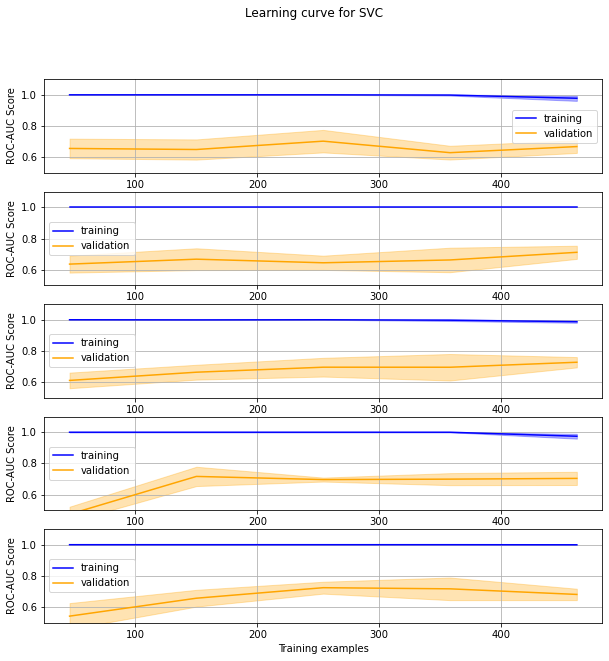

In [16]:

# Aantal splits
N_SPLITS = 5

rs = StratifiedShuffleSplit(n_splits=N_SPLITS, test_size=.3)

scores_svm = {'f1': [], 'accuracy': [], 'AUC': []}
fitted_clf_list_svm = []

fig, axs = plt.subplots(N_SPLITS, figsize=(10, 10))

for i, (train_index, test_index) in enumerate(rs.split(X, y)):

    # Data split
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_test = X.iloc[test_index]
    y_test = y[test_index]

    # Preprocessing
    scaler = StandardScaler()
    pca = PCA()
    selector = SelectKBest()

    # classifier 
    classifier = svm.SVC(probability=True)
    # Pipeline
    pipe = Pipeline(steps=[('scaler', scaler), ('select', selector), ('svm', classifier)])

    # GridSearch

    # Random grid:
    random_grid = {
        #'pca__n_components': [None, 10,50,100],
            'svm__C': list(np.arange(0.01,100, 5)),
            'svm__gamma': list(np.arange(0.001, 1, 0.05)), 
            'svm__kernel': ['rbf', 'poly', 'linear'],
            #'pca__n_components': [None] + list(np.arange(1, 101, 20))} 
            'select__k': np.arange(2, 150)}


    search = RandomizedSearchCV(pipe, random_grid, cv=3, verbose=5, scoring = 'f1', n_iter= 20)
    search.fit(X_train, y_train)
    best_clf = search.best_estimator_
    fitted_clf_list_svm.append(search)

    # evaluation
    y_pred = best_clf.predict(X_test)
    y_score = best_clf.predict_proba(X_test)
    scores_svm['f1'] += [f1_score(y_test, y_pred)]
    scores_svm['accuracy'] += [accuracy_score(y_test, y_pred)]
    scores_svm['AUC'] += [roc_auc_score(y_test, y_score[:,1])]

    # Predictions
    scores_svm[f'probs_split_{i+1}'] = y_score
    scores_svm[f'labels_split_{i+1}'] = list(y_test)
    
    plot_learning_curve(best_clf, X_train, y_train, axs[i])
    fig.suptitle(f'Learning curve for {str(type(best_clf[-1])).split(".")[-1][:-2]}')
plt.show()

### Results - Overall metrics

In [17]:
print('F1-scores:')
print(f"{scores_svm['f1']}, mean: {np.mean(scores_svm['f1'])}")
print('Accuracy:')
print(f"{scores_svm['accuracy']}, mean: {np.mean(scores_svm['accuracy'])}")
print('AUC:')
print(f"{scores_svm['AUC']}, mean: {np.mean(scores_svm['AUC'])}")

F1-scores:
[0.4468085106382979, 0.45977011494252873, 0.5454545454545454, 0.380952380952381, 0.40449438202247195], mean: 0.44749598680204494
Accuracy:
[0.7911646586345381, 0.8112449799196787, 0.8594377510040161, 0.7911646586345381, 0.7871485943775101], mean: 0.8080321285140564
AUC:
[0.7348115299334811, 0.6875831485587584, 0.846230598669623, 0.6260532150776053, 0.6505543237250555], mean: 0.7090465631929046


### Results - Hyperparameter search

In [18]:
import pandas as pd
for i, clf in enumerate(fitted_clf_list_svm): 
    print(f'Results for split {i+1}:')
    param_df = pd.DataFrame(clf.cv_results_)

    # columns to drop from dataframe:
    param_df = param_df.drop(['std_fit_time', 'mean_score_time', 'std_score_time'], axis=1)
    cols = [c for c in param_df.columns if c.lower()[:5] != 'split']
    
    param_df = param_df[cols].sort_values(by='rank_test_score')
    display(param_df.head(5))

Results for split 1:


,mean_fit_time,param_svm__kernel,param_svm__gamma,param_svm__C,param_select__k,params,mean_test_score,std_test_score,rank_test_score
16,0.608115,linear,0.051,25.01,125,"{'svm__kernel': 'linear', 'svm__gamma': 0.0510...",0.391804,0.097665,1
9,0.395438,poly,0.851,35.01,171,"{'svm__kernel': 'poly', 'svm__gamma': 0.851000...",0.386224,0.032028,2
12,0.369815,poly,0.551,85.01,115,"{'svm__kernel': 'poly', 'svm__gamma': 0.551, '...",0.383951,0.134642,3
19,0.315992,poly,0.501,85.01,121,"{'svm__kernel': 'poly', 'svm__gamma': 0.501, '...",0.381630,0.134806,4
18,0.386183,poly,0.251,10.01,102,"{'svm__kernel': 'poly', 'svm__gamma': 0.251, '...",0.376072,0.128531,5


Results for split 2:


,mean_fit_time,param_svm__kernel,param_svm__gamma,param_svm__C,param_select__k,params,mean_test_score,std_test_score,rank_test_score
7,0.367446,linear,0.401,80.01,185,"{'svm__kernel': 'linear', 'svm__gamma': 0.401,...",0.462601,0.031974,1
11,0.878370,linear,0.651,85.01,100,"{'svm__kernel': 'linear', 'svm__gamma': 0.651,...",0.455556,0.027499,2
6,0.345576,linear,0.001,5.01,170,"{'svm__kernel': 'linear', 'svm__gamma': 0.001,...",0.454713,0.024676,3
17,0.500248,linear,0.201,25.01,114,"{'svm__kernel': 'linear', 'svm__gamma': 0.201,...",0.440682,0.024904,4
12,0.314804,poly,0.451,35.01,114,"{'svm__kernel': 'poly', 'svm__gamma': 0.451, '...",0.438971,0.073653,5


Results for split 3:


,mean_fit_time,param_svm__kernel,param_svm__gamma,param_svm__C,param_select__k,params,mean_test_score,std_test_score,rank_test_score
12,0.312628,rbf,0.001,95.01,150,"{'svm__kernel': 'rbf', 'svm__gamma': 0.001, 's...",0.436603,0.024449,1
15,0.420980,linear,0.201,5.01,162,"{'svm__kernel': 'linear', 'svm__gamma': 0.201,...",0.416747,0.019727,2
18,0.367402,linear,0.051,75.01,194,"{'svm__kernel': 'linear', 'svm__gamma': 0.0510...",0.411185,0.023411,3
5,0.445298,linear,0.951,95.01,159,"{'svm__kernel': 'linear', 'svm__gamma': 0.9510...",0.398800,0.025961,4
9,0.316937,poly,0.901,85.01,124,"{'svm__kernel': 'poly', 'svm__gamma': 0.901, '...",0.391669,0.029517,5


Results for split 4:


,mean_fit_time,param_svm__kernel,param_svm__gamma,param_svm__C,param_select__k,params,mean_test_score,std_test_score,rank_test_score
11,0.750855,linear,0.251,85.01,109,"{'svm__kernel': 'linear', 'svm__gamma': 0.251,...",0.453004,0.061914,1
13,0.325382,poly,0.601,85.01,179,"{'svm__kernel': 'poly', 'svm__gamma': 0.601000...",0.447262,0.012081,2
17,0.549963,linear,0.351,25.01,111,"{'svm__kernel': 'linear', 'svm__gamma': 0.3510...",0.445727,0.054366,3
18,0.345620,poly,0.251,80.01,143,"{'svm__kernel': 'poly', 'svm__gamma': 0.251, '...",0.435612,0.021304,4
3,0.387384,linear,0.751,55.01,157,"{'svm__kernel': 'linear', 'svm__gamma': 0.751,...",0.421467,0.047934,5


Results for split 5:


,mean_fit_time,param_svm__kernel,param_svm__gamma,param_svm__C,param_select__k,params,mean_test_score,std_test_score,rank_test_score
4,0.423855,linear,0.651,75.01,141,"{'svm__kernel': 'linear', 'svm__gamma': 0.651,...",0.421954,0.069445,1
18,0.304695,poly,0.851,20.01,138,"{'svm__kernel': 'poly', 'svm__gamma': 0.851000...",0.420790,0.049326,2
5,0.376853,linear,0.901,85.01,153,"{'svm__kernel': 'linear', 'svm__gamma': 0.901,...",0.417873,0.081297,3
9,0.336547,poly,0.751,30.01,110,"{'svm__kernel': 'poly', 'svm__gamma': 0.751, '...",0.408520,0.021064,4
8,0.354395,poly,0.951,65.01,144,"{'svm__kernel': 'poly', 'svm__gamma': 0.951000...",0.407918,0.056044,5


# Statistical analysis

### Create table of p-values (significant values are green)

In [19]:
classifiers_used = ['Random Forest', 'K-NN', 'Naive Bayes', 'SVM']

names = combinations(classifiers_used, 2)
#comb = combinations([scores_rf['f1'], scores_knn['f1'], scores_nb['f1'], scores_svm['f1']], 2)

# Terugveranderen!
#scores_rf = [0.25925925925925924, 0.37931034482758624, 0.18518518518518517, 0.1923076923076923, 0.22222222222222218]
#scores_knn = [0.3, 0.3157894736842105, 0.30508474576271183, 0.3333333333333333, 0.2857142857142857]
#scores_nb = [0.30769230769230765, 0.41666666666666663, 0.34375, 0.4266666666666667, 0.3684210526315789]
#scores_svm = [0.393939393939394, 0.5000000000000001, 0.4594594594594595, 0.43076923076923074, 0.47619047619047616]

comb = combinations([scores_rf['f1'], scores_knn['f1'], scores_nb['f1'], scores_svm['f1']], 2)

# Print the obtained combinations
p_values_table = pd.DataFrame(index=classifiers_used, columns=classifiers_used)

for name, scores in zip(list(names), list(comb)):
    _, p_value = ttest_rel(scores[0], scores[1])
    p_values_table[name[0]][name[1]] = p_value
    p_values_table[name[1]][name[0]] = p_value

In [20]:
def _color_green(val):
    color = 'grey' if val == '-' else ('green' if float(val) < 0.05 else 'black')
    return 'color: %s' % color

In [21]:
p_values_table = p_values_table.replace(pd.NA, '-')
p_values_table = p_values_table.style.applymap(_color_green)
display(p_values_table)

,Random Forest,K-NN,Naive Bayes,SVM
Random Forest,-,0.152203,0.034835,0.012026
K-NN,0.152203,-,0.044790,0.010722
Naive Bayes,0.034835,0.044790,-,0.184637
SVM,0.012026,0.010722,0.184637,-


#### Boxplot for F1-scores of the different ML algorithms used

Text(0.5, 1.0, 'Boxplot F1-scores on test sets')

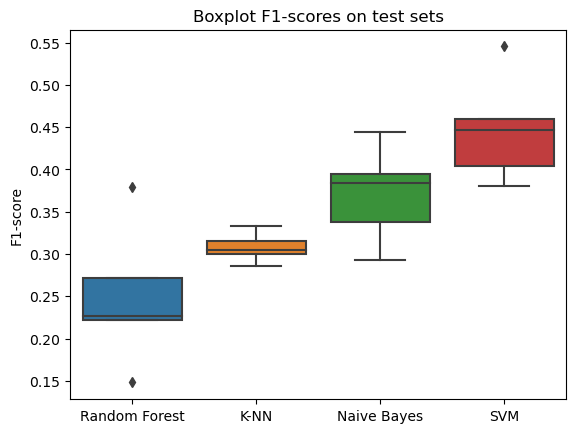

In [27]:
scores_df = pd.DataFrame({'Random Forest': scores_rf['f1'], 'K-NN': scores_knn['f1'], 'Naive Bayes': scores_nb['f1'], 'SVM': scores_svm['f1']})

ax = seaborn.boxplot(data=scores_df)
ax.set_ylabel('F1-score')
ax.set_title('Boxplot F1-scores on test sets')

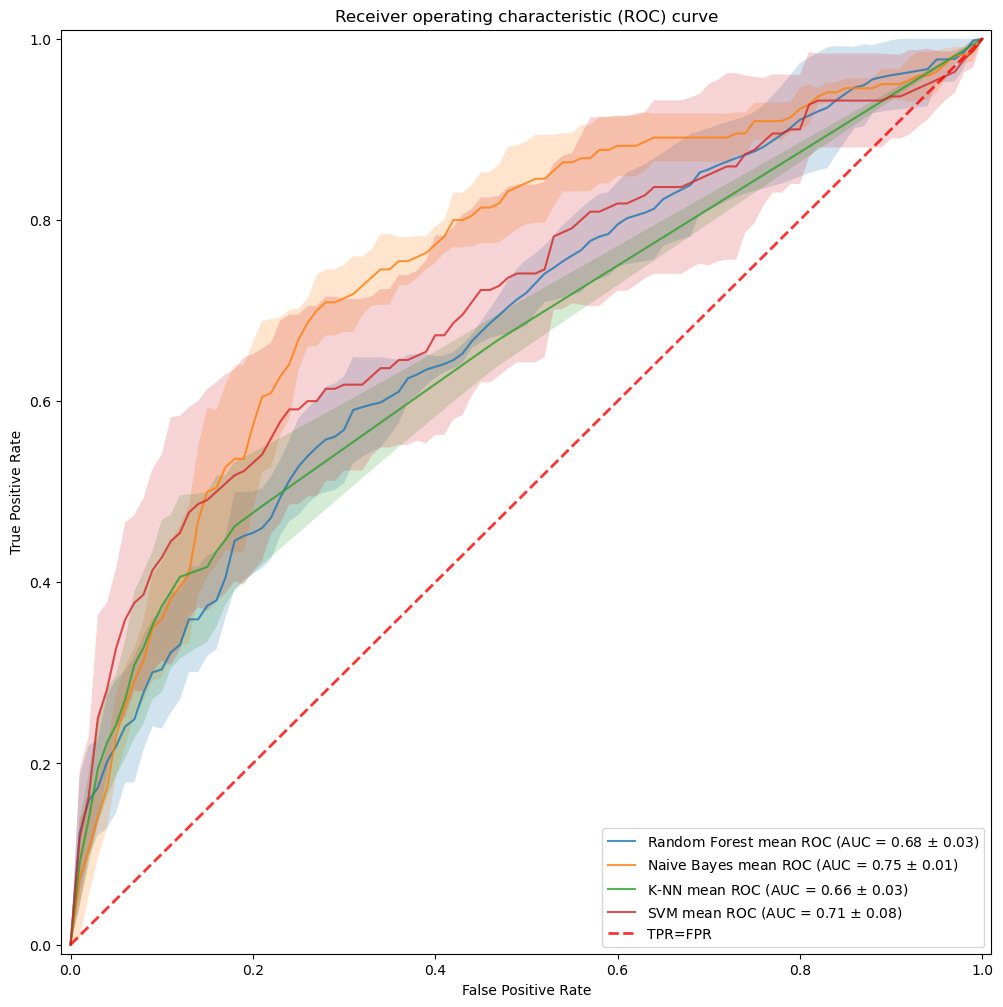

In [23]:
# Code adapted from:
# https://stackoverflow.com/questions/51442818/average-roc-curve-across-folds-for-multi-class-classification-case-in-sklearn

from sklearn.metrics import roc_curve, auc

plt.style.use('default')

scores_dict = [scores_rf, scores_nb, scores_knn, scores_svm]
classifiers_used = ['Random Forest', 'Naive Bayes', 'K-NN', 'SVM']

colors = ['darksalmon', 'gold', 'royalblue', 'mediumseagreen', 'violet']
plt.figure(figsize=(12, 12))

for dict, name in zip(scores_dict, classifiers_used):
    tprs = []
    aucs = []
    base_fpr = np.linspace(0, 1, 101)

    for i in range(N_SPLITS):
        fpr, tpr, _ = roc_curve(dict[f'labels_split_{i+1}'], dict[f'probs_split_{i+1}'][:, 1])
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)

    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    mean_auc = auc(base_fpr, mean_tprs)
    std_auc = np.std(aucs)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std

    plt.plot(base_fpr, mean_tprs, alpha = 0.8, label=r'%s mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (name, mean_auc, std_auc),)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, alpha = 0.2)

plt.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'r', label = 'TPR=FPR', alpha= 0.8)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic (ROC) curve')
plt.show()

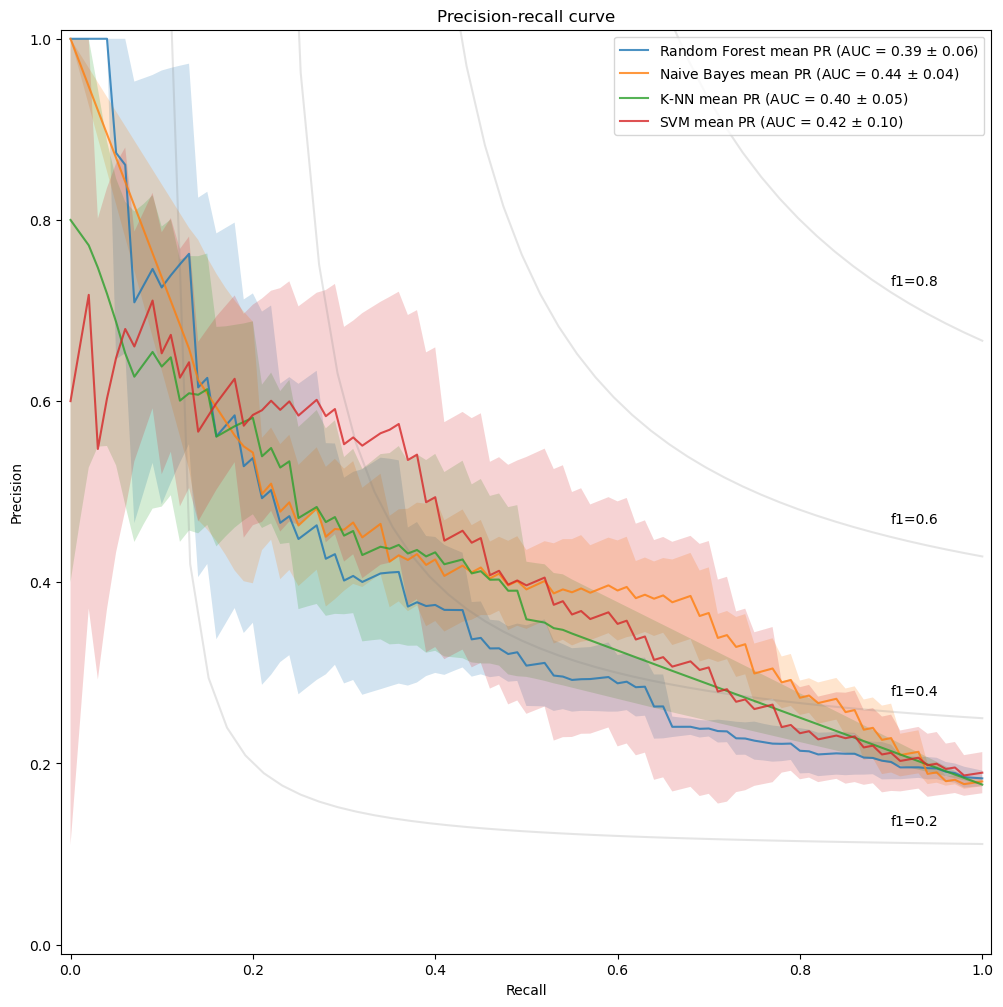

In [24]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(12, 12))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

for dict, name in zip(scores_dict, classifiers_used):
    precision = []
    pr_auc = []
    base_recall = np.linspace(0, 1, 101)

    for i in range(N_SPLITS):
        prec, rec, _ = precision_recall_curve(dict[f'labels_split_{i+1}'], dict[f'probs_split_{i+1}'][:, 1])
        prec = np.flip(prec)
        rec = np.flip(rec)
        auc_temp = auc(rec, prec)
        pr_auc.append(auc_temp)
        prec = np.interp(base_recall, rec, prec)
        precision.append(prec)

    precision = np.array(precision)
    mean_precisions = np.mean(precision, axis=0)
    std = precision.std(axis=0)

    mean_auc = np.mean(pr_auc)
    std_auc = np.std(pr_auc)

    plt.plot(base_recall, mean_precisions, alpha = 0.8, label=r'%s mean PR (AUC = %0.2f $\pm$ %0.2f)' % (name, mean_auc, std_auc),)
    

    prec_upper = np.minimum(mean_precisions + std, 1)
    prec_lower = mean_precisions - std
    plt.fill_between(base_recall, prec_lower, prec_upper, alpha = 0.2)

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc="upper right")
plt.title('Precision-recall curve')
plt.show()